In [ ]:
### Импорт зависимостей

In [0]:
import os

import numpy as np
import skimage.io
import matplotlib.pyplot as plt

### Исследование экземпляра из набора данных

Форма изображения: 32 пикселя - высота, 32 пикселя - ширина, 4 цветовых канала

In [2]:
bmw = skimage.io.imread('./data/bmw/bmw1.png')
bmw.shape

(32, 32, 4)

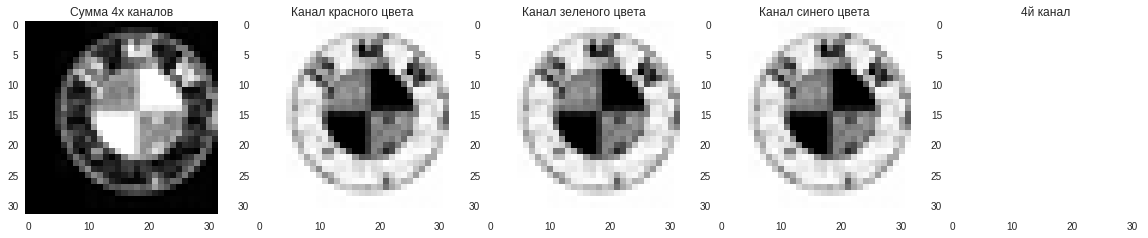

In [3]:
fig, ax = plt.subplots(1,5,figsize=(20,5))
ax[0].grid(False)
ax[0].set_title('Сумма 4х каналов')
ax[0].imshow(bmw)

ax[1].grid(False)
ax[1].set_title('Канал красного цвета')
ax[1].imshow(bmw[:,:,0])

ax[2].grid(False)
ax[2].set_title('Канал зеленого цвета')
ax[2].imshow(bmw[:,:,1])

ax[3].grid(False)
ax[3].set_title('Канал синего цвета')
ax[3].imshow(bmw[:,:,2])

ax[4].grid(False)
ax[4].set_title('4й канал')
ax[4].imshow(bmw[:,:,3])

In [4]:
# Последний канал явно не содержит никакой информацииб т.к. имеет нулевую дисперсию
bmw[:,:,3].std()

0.0

In [5]:
# Информация в цветовых каналах дублируется т.к. дисперсия у каждого канала одинаковая 
bmw[:,:,0].std() == bmw[:,:,1].std()  == bmw[:,:,2].std()

True

### Загрузка изображений в оперативную память и их очистка от лишней информации. Добавление меток

In [0]:
def load_images(path):
    '''Функция загружает все изображения в указанной папке, склеивает все каналы изображения в один. 
    Возвращает список всех изображений из заданной папки'''
    fnames = next(os.walk(path))[2] # Получение списка файлов в заданной папке
    
    img_set = []
    for fname in fnames:
        try:
            img = skimage.io.imread(os.path.join(path, fname)) # Загрузка изображения 
            img = img[:,:,:3].mean(axis=2) # Усреднение каналов изображения к одному
            img_set.append(img)
        except FileNotFoundError:
            print('Ошибка загрузки файла {0}'.format(fname))
    return img_set

In [0]:
alfaromeo_imgs = load_images('./data/alfaromeo/') # Загрузка всех изображений класса
alfaromeo_labels = [[1,0,0,0,0]]*len(alfaromeo_imgs) # Пометка изображений этого класса как класс №1

In [0]:
bmw_imgs = load_images('./data/bmw/') # Загрузка всех изображений класса
bmw_labels = [[0,1,0,0,0]]*len(bmw_imgs) # Пометка изображений этого класса как класс №2

In [0]:
chevrolet_imgs = load_images('./data/chevrolet/') # Загрузка всех изображений класса
chevrolet_labels = [[0,0,1,0,0]]*len(chevrolet_imgs) # Пометка изображений этого класса как класс №3

In [0]:
honda_imgs = load_images('./data/honda/') # Загрузка всех изображений класса
honda_labels = [[0,0,0,1,0]]*len(honda_imgs) # Пометка изображений этого класса как класс №4

In [0]:
# Генерация изображений не принадлежащих ни одному из 4х классов
trash_imgs = [(alfaromeo_imgs[i] + bmw_imgs[i] + chevrolet_imgs[i] + honda_imgs[i])/4 for i in range(200)]
trash_labels = [[0,0,0,0,1]]*len(trash_imgs) # Пометка изображений этого класса как класс №5

In [0]:
# Объединение наборов в один
input_data = alfaromeo_imgs + bmw_imgs + chevrolet_imgs + honda_imgs + trash_imgs
output_data = alfaromeo_labels + bmw_labels + chevrolet_labels + honda_labels + trash_labels

In [0]:
# Преобрвазование данных из python-list в numpy array
input_data = np.array(input_data)
output_data = np.array(output_data)

In [0]:
# Преобразование квадратной матрицы изображения в вектор длинной 32x32px
input_data = input_data.reshape(1100, -1)

In [0]:
# Нормализация входных данных к интервалу от 0 до 1
input_data = input_data - input_data.min()
input_data = input_data / input_data.max()

In [0]:
# Проверка размерности данных
assert input_data.shape[0] == output_data.shape[0]

In [0]:
# Разбивка набора данных на тренировачную и тестовую части
indexes = np.arange(input_data.shape[0]) 
np.random.shuffle(indexes)
train_indexes = indexes[len(indexes)//10:]
test_indexes = indexes[:len(indexes)//10]

X_train, y_train = input_data[train_indexes], output_data[train_indexes]
X_test, y_test = input_data[test_indexes], output_data[test_indexes]

In [18]:
print('train: x - {0}, y - {1}'.format(X_train.shape, y_train.shape))
print('test: x - {0}, y - {1}'.format(X_test.shape, y_test.shape))

train: x - (990, 1024), y - (990, 5)
test: x - (110, 1024), y - (110, 5)


### Создание и обучение модели

In [0]:
def relu(x):
    '''Нелинейное преобразование'''
    return np.maximum(x, 0)

def drelu(x):
    '''Производная функции relu'''
    return 1.0 * (x > 0)

def softmax(z):
    '''Логистическое преобразование'''
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

def feed_forward(X, weights):
    '''Прямой проход входных данных через все слои'''
    activations = [X]
    for w in weights:
        activations.append(relu(activations[-1].dot(w)))
    activations[-1] = softmax(activations[-1])
    return activations

def grads(X, Y, weights):
    '''Запуск прямого прохода, расчет величины ошибки и вычисление градиента для корректировки весов'''
    activations = feed_forward(X, weights)
    grads = np.empty_like(weights)
    delta = activations[-1] - Y # Расчет величины ошибки
    grads[-1] = activations[-2].T.dot(delta)
    for i in range(len(activations)-2, 0, -1):
        delta = drelu(activations[i]) * delta.dot(weights[i].T)
        grads[i-1] = activations[i-1].T.dot(delta)
    return grads / len(X)

In [0]:
# Инициализация весов и настройка параметров обучения
weights = [np.random.randn(*w) * 0.1 for w in [(1024, 512), (512,256), (256,128), (128,5)]]
num_epochs, batch_size, learn_rate = 200, 200, 0.005

In [77]:
# Минимизация функции потерь
for i_epoch in range(num_epochs):
    for i_batch in range(0, len(X_train), batch_size):
        # Разделение набора на батчи
        X, Y = X_train[i_batch:i_batch+batch_size], y_train[i_batch:i_batch+batch_size]
        
        # Вычисление градиента и корректировка весов
        weights -= learn_rate * grads(X, Y, weights)
        
    # Оценка точности
    predict_proba = softmax(feed_forward(X_test, weights)[-1])
    prediction = np.argmax(predict_proba, axis=1)
    score = np.mean(prediction == np.argmax(y_test, axis=1))
    if i_epoch%10 == 0:
        print('accuracy: {0:.4}'.format(score))

accuracy: 0.3364
accuracy: 0.5091
accuracy: 0.5636
accuracy: 0.5909
accuracy: 0.5909
accuracy: 0.6091
accuracy: 0.6364
accuracy: 0.6455
accuracy: 0.6636
accuracy: 0.6818
accuracy: 0.7
accuracy: 0.7182
accuracy: 0.7273
accuracy: 0.7273
accuracy: 0.7364
accuracy: 0.7455
accuracy: 0.7455
accuracy: 0.7455
accuracy: 0.7364
accuracy: 0.7545


In [80]:
# Получение предсказаний первых 100 изображений из отложенного тестового набора
activation = feed_forward(X_test[:100], weights)[-1]
proba = softmax(activation)
np.argmax(proba, axis=1)

array([1, 1, 2, 3, 1, 2, 4, 3, 1, 3, 1, 2, 3, 3, 4, 1, 2, 2, 0, 4, 1, 4,
       2, 0, 1, 3, 1, 1, 4, 2, 1, 1, 0, 1, 2, 4, 4, 2, 0, 3, 1, 3, 1, 3,
       0, 4, 4, 2, 1, 1, 0, 3, 0, 2, 3, 2, 0, 4, 3, 1, 2, 2, 0, 1, 2, 2,
       0, 4, 0, 1, 0, 1, 3, 4, 3, 4, 0, 3, 0, 1, 0, 1, 4, 2, 0, 2, 1, 0,
       3, 2, 4, 1, 3, 2, 2, 2, 1, 4, 1, 0])

In [82]:
# Истинные метки классов для этих первых 100 изображений
np.argmax(y_test[:100], axis=1)

array([2, 3, 2, 2, 1, 2, 2, 1, 1, 3, 1, 2, 3, 3, 4, 2, 2, 2, 1, 4, 1, 4,
       1, 0, 1, 3, 1, 1, 4, 2, 2, 1, 0, 1, 3, 4, 4, 3, 0, 3, 1, 3, 1, 0,
       0, 0, 4, 2, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0, 1, 2, 2, 0, 3, 2, 2,
       0, 4, 0, 0, 4, 0, 3, 4, 3, 4, 0, 3, 0, 1, 0, 1, 4, 2, 4, 2, 0, 0,
       3, 2, 4, 1, 3, 2, 2, 3, 1, 4, 3, 0])

In [86]:
# 1 - правильно распознанный класс, 0 - предсказанный класс не совпал с целевым
score = np.equal(np.argmax(proba, axis=1), np.argmax(y_test[:100], axis=1)).astype(int)
score

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1])

In [87]:
# Процент правильно распознанных изображений. 
score.sum() / score.shape[0] # т.е. 75% изображений были распознаны верно

0.75